In [ ]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_error,r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
rawdf = pd.read_csv('drive/My Drive/Colab Notebooks/Proyecto Final/fco_production.csv', sep=',')
print(f"Number of Rows = {rawdf.shape[0]}")
rawdf.head(5)

Number of Rows = 17436


,sup_cod_id,wk_type,pdn_date,pdn_unit_price,pdn_quantity,pdn_amount_paid,pdn_total_amount,pdn_num_week,pdn_year,pdn_month,pdn_day
0,SUP0020009,Productor,2021-12-27,0.44,0.06,0,0.0264,52,2021,12,27
1,SUP0070043,Productor,2021-12-27,0.40,0.10,0,0.0400,52,2021,12,27
2,SUP0080045,Productor,2021-12-27,0.40,0.10,0,0.0400,52,2021,12,27
3,SUP0140044,Productor,2021-12-27,0.46,0.04,0,0.0184,52,2021,12,27
4,SUP0090081,Productor,2021-12-27,0.40,0.10,0,0.0400,52,2021,12,27


In [ ]:
slvdf = rawdf[(rawdf['wk_type'] == 'Productor') & (rawdf['pdn_year'] > 2021)].copy()
slvdf['pdn_num_week'] = slvdf['pdn_num_week'].astype(str).str.zfill(2)
slvdf['pdn_date'] = pd.to_datetime(slvdf['pdn_date'])
slvdf['yvarqty'] = slvdf['pdn_quantity'].round().astype(int)
slvdf['xvarper'] = (slvdf['pdn_date'] - pd.to_timedelta(slvdf['pdn_date'].dt.weekday, unit='d'))
slvdf= slvdf[slvdf['yvarqty'] != 0]
print(f"Number of Rows = {slvdf.shape[0]}")
slvdf.head(5)


Number of Rows = 11211


,sup_cod_id,wk_type,pdn_date,pdn_unit_price,pdn_quantity,pdn_amount_paid,pdn_total_amount,pdn_num_week,pdn_year,pdn_month,pdn_day,yvarqty,xvarper
3096,SUP0020009,Productor,2022-07-02,0.44,120.0,0,52.80,26,2022,7,2,120,2022-06-27
3098,SUP0070043,Productor,2022-07-02,0.40,51.0,0,20.40,26,2022,7,2,51,2022-06-27
3099,SUP0080045,Productor,2022-07-02,0.40,40.0,0,16.00,26,2022,7,2,40,2022-06-27
3100,SUP0140044,Productor,2022-07-02,0.46,42.0,0,19.32,26,2022,7,2,42,2022-06-27
3101,SUP0090081,Productor,2022-07-02,0.40,58.0,0,23.20,26,2022,7,2,58,2022-06-27


In [ ]:
dataEnd= slvdf[['sup_cod_id','xvarper','yvarqty']].copy()
print(f"Number of Rows = {dataEnd.shape[0]}")
dataEnd.head(5)

Number of Rows = 11211


,sup_cod_id,xvarper,yvarqty
3096,SUP0020009,2022-06-27,120
3098,SUP0070043,2022-06-27,51
3099,SUP0080045,2022-06-27,40
3100,SUP0140044,2022-06-27,42
3101,SUP0090081,2022-06-27,58


In [ ]:
dfprov=dataEnd.copy()
dfprov = dfprov.sort_values(by='xvarper', ascending=True)
dfprov.head(5)

,sup_cod_id,xvarper,yvarqty
3334,SUP0020009,2022-01-03,119
3372,SUP0080045,2022-01-03,38
3373,SUP0140044,2022-01-03,76
3374,SUP0090081,2022-01-03,49
3375,SUP0100080,2022-01-03,24


In [ ]:
# Agrupar po
result = dfprov.groupby(['sup_cod_id', 'xvarper', ]).agg(
                                                    ysumqty=('yvarqty', 'sum')).reset_index()

result['xvarper'] = pd.to_datetime(result['xvarper'])

dftrain=result[(result['xvarper']<'2024-07-22')   ]


# dftrain=dftrain[['xvarper','yvarqty']]
# dftrain.set_index('xvarper', inplace=True)

# # Establecer la frecuencia del índice a semanal
# result.index.freq = 'W-MON'
dftrain


,sup_cod_id,xvarper,ysumqty
0,SUP0010004,2022-12-19,340
1,SUP0010004,2022-12-26,415
2,SUP0010004,2023-01-02,401
3,SUP0010004,2023-01-09,390
4,SUP0010004,2023-01-16,342
...,...,...,...
1803,SUP0270101,2024-06-17,212
1804,SUP0270101,2024-06-24,222
1805,SUP0270101,2024-07-01,213
1806,SUP0270101,2024-07-08,194


In [ ]:
# Realizar la prueba ADF
resultx = adfuller(dftrain['suma_pdn_quantity'])
print('Estadística ADF:', resultx[0])
print('p-valor:', resultx[1])
print('Número de lags:', resultx[2])
print('Número de observaciones:', resultx[3])
print('Valores críticos:')
for key, value in resultx[4].items():
    print(f'   {key}: {value}')

Estadística ADF: -0.31285827948499506
p-valor: 0.9236633692934737
Número de lags: 3
Número de observaciones: 129
Valores críticos:
   1%: -3.482087964046026
   5%: -2.8842185101614626
   10%: -2.578864381347275


<Axes: title={'center': 'Entrega de materia prima por semana'}, xlabel='week'>

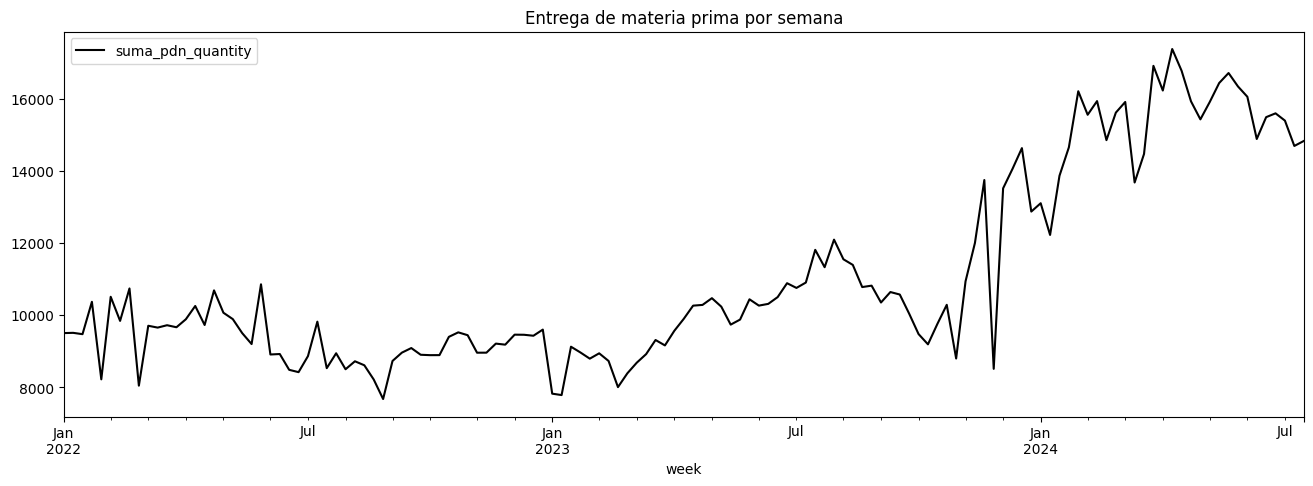

In [ ]:
#Grafico de Ventas totales por MesAño
dftrain.plot(kind='line',y='suma_pdn_quantity',xlabel='week',title="Entrega de materia prima por semana",figsize=(16,5),color = "black")

EDA

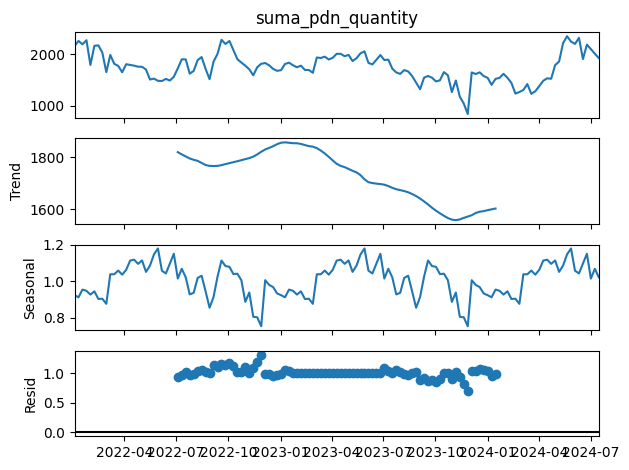

In [ ]:
# Se realiza una descomposición estacional de la serie temporal de ventas utilizando un modelo multiplicativo
df_decompose = dftrain.copy()
#df_decompose.index = df_decompose.index.to_timestamp()
decompose_result = seasonal_decompose(df_decompose['suma_pdn_quantity'],model='multiplicative',period=52)
decompose_result.plot()
plt.show()

In [ ]:

# Aplicar diferenciación para hacer la serie estacionaria
dftrain['litros_diff'] = dftrain['suma_pdn_quantity'].diff().dropna()

# Ajustar un modelo ARIMA (p, d, q)
# Para este ejemplo, asumimos que p=2, d=1, q=2
model = ARIMA(dftrain['suma_pdn_quantity'], order=(2, 1, 2))
model_fit = model.fit()

# Resumen del modelo
print(model_fit.summary())

# Predicciones
predictions = model_fit.forecast(steps=5)
print("Predicciones para las próximas 5 semanas:")
predictions

# # Graficar las predicciones
# plt.figure(figsize=(12, 6))
# plt.plot(dftrain['suma_pdn_quantity'], label='Datos Históricos')
# plt.plot(pd.date_range(start=dftrain.index[-1] + pd.Timedelta(weeks=1), periods=10, freq='W'), predictions, label='Predicciones', color='orange')
# plt.title('Predicciones de ARIMA')
# plt.xlabel('Fecha')
# plt.ylabel('Litros')
# plt.axhline(y=50, color='r', linestyle='--', label='Nivel Base')
# plt.legend()
# plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:      suma_pdn_quantity   No. Observations:                  133
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -851.283
Date:                Tue, 03 Sep 2024   AIC                           1712.566
Time:                        03:57:46   BIC                           1726.980
Sample:                    01-03-2022   HQIC                          1718.424
                         - 07-15-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0505      0.114     -0.445      0.657      -0.273       0.172
ar.L2          0.8001      0.103      7.806      0.000       0.599       1.001
ma.L1         -0.1772      0.248     -0.713      0.4

,predicted_mean
2024-07-22,1945.202820
2024-07-29,1882.911676
2024-08-05,1905.422234
2024-08-12,1854.443667
2024-08-19,1875.029058


In [ ]:
df_reset = predictions.reset_index()
df_reset

,index,predicted_mean
0,2024-07-22,1945.202820
1,2024-07-29,1882.911676
2,2024-08-05,1905.422234
3,2024-08-12,1854.443667
4,2024-08-19,1875.029058


In [ ]:
dfpredict=result[(result['fist_day_wk']>'2024-07-15')   ]
dfpredict

,fist_day_wk,pdn_num_week,suma_pdn_quantity
133,2024-07-22,wk30,1861.0
134,2024-07-29,wk31,1803.0
135,2024-08-05,wk32,1768.0
136,2024-08-12,wk33,1647.0
137,2024-08-19,wk34,1625.0
138,2024-08-26,wk35,240.0


In [ ]:
df_merged = pd.merge(dfpredict, df_reset,
                     left_on='fist_day_wk',
                     right_on='index',
                     how='outer')

df_merged=df_merged[['pdn_num_week','suma_pdn_quantity','predicted_mean']]
df_merged=df_merged.dropna()
df_merged['pdn_num_week']=df_merged['pdn_num_week'].str.replace('wk','').astype(int)
df_merged=df_merged[(df_merged['pdn_num_week']!=35)   ]
df_merged['predicted_mean']=df_merged['predicted_mean'].round().astype(int)
df_merged['suma_pdn_quantity']=df_merged['suma_pdn_quantity'].round().astype(int)
df_merged

,pdn_num_week,suma_pdn_quantity,predicted_mean
0,30,1861,1945
1,31,1803,1883
2,32,1768,1905
3,33,1647,1854
4,34,1625,1875


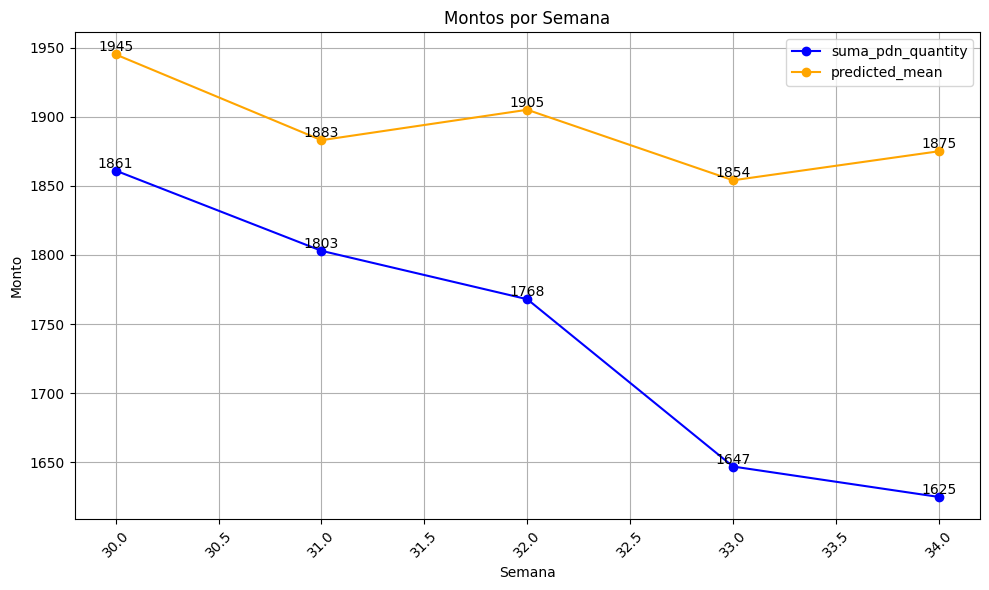

In [ ]:
plt.figure(figsize=(10, 6))  # Tamaño de la figura
plt.plot(df_merged['pdn_num_week'], df_merged['suma_pdn_quantity'], marker='o', label='suma_pdn_quantity', color='blue')
plt.plot(df_merged['pdn_num_week'], df_merged['predicted_mean'], marker='o', label='predicted_mean', color='orange')

# Mostrar los valores en cada punto
for i, row in df_merged.iterrows():
    plt.text(row['pdn_num_week'], row['suma_pdn_quantity'], str(row['suma_pdn_quantity']),
             ha='center', va='bottom', color='black')
    plt.text(row['pdn_num_week'], row['predicted_mean'], str(row['predicted_mean']),
             ha='center', va='bottom', color='black')

# Personalizar la gráfica
plt.title('Montos por Semana')
plt.xlabel('Semana')
plt.ylabel('Monto')
plt.xticks(rotation=45)  # Rotar etiquetas del eje X si es necesario
plt.legend()  # Mostrar la leyenda
plt.grid()  # Mostrar la cuadrícula

# Mostrar la gráfica
plt.tight_layout()  # Ajustar el layout
plt.show()